# 1. 분석환경 설정하기

## 1.1. 경로 설정

In [ ]:
cd ./datasets

C:\Users\stat\Documents\bigcontest\datasets


## 1.2. 라이브러리 설정

In [ ]:
# !pip install missingno
# !pip install xgboost

In [ ]:
# 1. 기본
import pandas as pd
from datetime import datetime

# 2. 데이터 가져오기
import numpy as np

# 3. 시각화패키지
import missingno as msno
import matplotlib.pyplot as plt

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler

# 5. 앙상블 모델
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# 6. 모델 검정
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import RocCurveDisplay

# 2. 데이터 불러오기

In [ ]:
user_spec = pd.read_csv('user_spec.csv', encoding='CP949')
loan_result = pd.read_csv('loan_result.csv')
log_data = pd.read_csv('log_data.csv')

In [ ]:
display(user_spec.info())
display(loan_result.info())
display(log_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394216 entries, 0 to 1394215
Data columns (total 17 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   application_id                       1394216 non-null  int64  
 1   user_id                              1394216 non-null  int64  
 2   birth_year                           1381255 non-null  float64
 3   gender                               1381255 non-null  float64
 4   insert_time                          1394216 non-null  object 
 5   credit_score                         1289101 non-null  float64
 6   yearly_income                        1394126 non-null  float64
 7   income_type                          1394131 non-null  object 
 8   company_enter_month                  1222456 non-null  float64
 9   employment_type                      1394131 non-null  object 
 10  houseown_type                        1394131 non-null  object 
 11

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527363 entries, 0 to 13527362
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   application_id         int64  
 1   loanapply_insert_time  object 
 2   bank_id                int64  
 3   product_id             int64  
 4   loan_limit             float64
 5   loan_rate              float64
 6   is_applied             float64
dtypes: float64(3), int64(3), object(1)
memory usage: 722.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17843993 entries, 0 to 17843992
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   event           object
 2   timestamp       object
 3   mp_os           object
 4   mp_app_version  object
 5   date_cd         object
dtypes: int64(1), object(5)
memory usage: 816.8+ MB


None

# 3. 데이터 전처리

## 3.1. age 변수 추가

In [ ]:
user_spec['age'] = (2022 - user_spec['birth_year'])

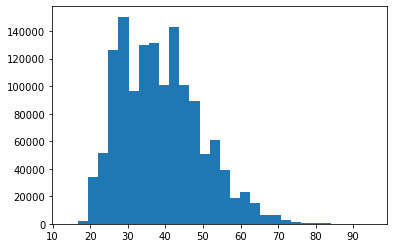

In [ ]:
plt.hist(user_spec['age'], bins=30)
plt.show()

## 3.2. 근속달수 변수 추가

In [ ]:
user_spec['insert_time'] = pd.to_datetime(user_spec['insert_time'])
insert_year = user_spec['insert_time'].dt.year
insert_month = user_spec['insert_time'].apply(lambda x : str(x).split('-')[0]+str(x).split('-')[1])

In [ ]:
# 근속연수 _근속달수를 계산하기 위한 단계적 변수추가
user_spec['enter_year'] = user_spec['company_enter_month'].fillna(insert_year).apply(lambda x : int(str(x)[0:4]))
user_spec['continuous_service_year'] = insert_year - user_spec['enter_year']

### 3.2.1 근속연수 이상치 제거

In [ ]:
year_index_1 = user_spec[(user_spec['enter_year']-user_spec['birth_year'])<15].index
user_spec = user_spec.drop(index=year_index_1)
year_index_2 = user_spec[user_spec['continuous_service_year']>50].index
user_spec = user_spec.drop(index=year_index_2)

In [ ]:
# 근속달수
user_spec['enter_month'] = user_spec['company_enter_month'].fillna(insert_month).apply(lambda x : int(str(x)[4:6]))
user_spec['enter_month'] 
user_spec['continuous_service_month'] = user_spec['continuous_service_year']*12 + insert_month.apply(lambda x : int(str(x)[-2:])) - user_spec['enter_month']
conti_month_counts = user_spec['continuous_service_month'].value_counts().sort_index()

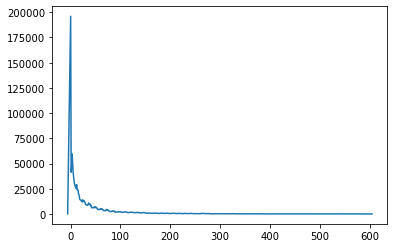

In [ ]:
plt.plot(conti_month_counts.index, conti_month_counts)
plt.show()

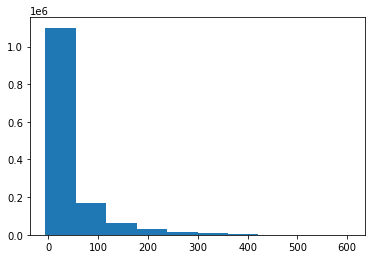

In [ ]:
plt.hist(user_spec['continuous_service_month'])
plt.show()

## 3.3. 신청시간대 변수 추가

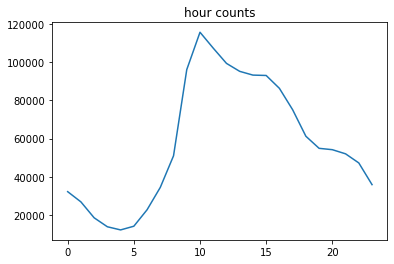

In [ ]:
user_spec['insert_hour'] = 0
user_spec['insert_hour'] = pd.to_datetime(user_spec['insert_time']).dt.hour

hour_counts = user_spec['insert_hour'].value_counts().sort_index()
plt.plot(hour_counts.index, hour_counts)
plt.title('hour counts')
plt.show()

## 3.4. 개인회생자 여부(pr) 변수 추가

In [ ]:
drop_index = user_spec[(user_spec['personal_rehabilitation_yn']==0) & (user_spec['personal_rehabilitation_complete_yn'].notnull())].index
user_spec = user_spec.drop(index=drop_index)
user_spec['pr'] = 0
user_spec['pr'][user_spec['personal_rehabilitation_complete_yn'].isnull()] = 1
user_spec['pr'][(user_spec['personal_rehabilitation_yn']==1) & (user_spec['personal_rehabilitation_complete_yn']==0)] = 2
user_spec['pr'][(user_spec['personal_rehabilitation_yn']==1) & (user_spec['personal_rehabilitation_complete_yn']==1)] = 3
user_spec['pr'].value_counts()

C:\Users\stat\AppData\Local\Temp\ipykernel_11452\1847409481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_spec['pr'][user_spec['personal_rehabilitation_complete_yn'].isnull()] = 1
C:\Users\stat\AppData\Local\Temp\ipykernel_11452\1847409481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_spec['pr'][(user_spec['personal_rehabilitation_yn']==1) & (user_spec['personal_rehabilitation_complete_yn']==0)] = 2
C:\Users\stat\AppData\Local\Temp\ipykernel_11452\1847409481.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

1    1202883
2      11356
3       1348
Name: pr, dtype: int64

## 3.5. credit_score 범주화
> credit score 분포-> 범주화

In [ ]:
credit = user_spec['credit_score'].value_counts().sort_index()

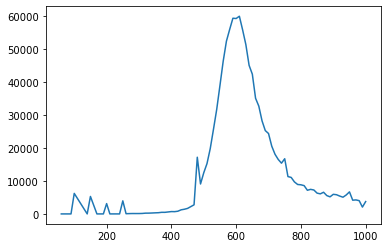

In [ ]:
plt.plot(credit.index, credit)

In [ ]:
standard = [0, 334, 453, 529, 629, 697, 767, 834, 890, 941, 1000]
label = [x for x in range(len(standard)-1,0,-1)]

user_spec['credit_rate'] = pd.cut(user_spec['credit_score'], standard, right=True, labels=label)

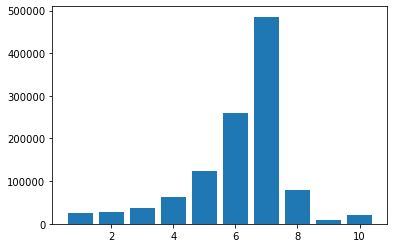

In [ ]:
credit_rate_counts = user_spec['credit_rate'].value_counts().sort_index(ascending=False)
plt.bar(credit_rate_counts.index, credit_rate_counts)
plt.show()

In [ ]:
user_spec = user_spec.astype({'credit_rate':'float'})

## 3.6. 문자열 변환

In [ ]:
# 문자열 변환 함수 
def change_lang(target,kor, eng):
  for i in range(len(kor)):
   target = str(target).replace(kor[i], eng[i])
  return target

In [ ]:
# purpose
kor = ['생활비', '대환대출', '사업자금', '기타', '전월세보증금', '주택구입','투자','자동차구입']
eng = ['LIVING','SWITCHLOAN','BUSINESS','ETC','HOUSEDEPOSIT','BUYHOUSE','INVEST','BUYCAR'] 

user_spec['purpose'] = user_spec['purpose'].apply(change_lang, args=(kor, eng))

In [ ]:
user_spec.dropna(subset=['houseown_type'],inplace=True)

In [ ]:
# houseown_type, employment_type, purpose 범주변환
def change(x, list):
    return list.index(x)

In [ ]:
list = ['전월세', '기타가족소유','자가','배우자']
user_spec['houseown_type'] = user_spec['houseown_type'].apply(change, args=[list])

In [ ]:
list = ['정규직','계약직','일용직','기타']
user_spec['employment_type'] = user_spec['employment_type'].apply(change, args=[list])

In [ ]:
list = ['LIVING','SWITCHLOAN','BUSINESS','ETC','HOUSEDEPOSIT','BUYHOUSE','INVEST','BUYCAR'] 
user_spec['purpose'] = user_spec['purpose'].apply(change, args=[list])

In [ ]:
list = ['EARNEDINCOME', 'OTHERINCOME', 'PRIVATEBUSINESS', 'FREELANCER', 'EARNEDINCOME2', 'PRACTITIONER']
user_spec['income_type'] = user_spec['income_type'].apply(change, args=[list])

# 4. 결측치 제거

## 4.1. 결측치 제거 (user_id, yearly_income 기준)

In [ ]:
user_spec=user_spec.dropna(subset=['user_id', 'yearly_income'])

## 4.2. 은행에서 제공 되지 않은 데이터 - 행기준으로 제거

In [ ]:
loan_result=loan_result.dropna(subset=['loan_limit', 'loan_rate'])

## 4.3. 파생변수 만들 때 생성된 변수 제거

In [ ]:
user_spec = user_spec.drop(['birth_year', 'enter_year', 'enter_month','continuous_service_year', 'company_enter_month', 'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn', 'credit_score'], axis=1) 

# 5. train, test 데이터 분리

## 5.1. 6월 데이터를 test로 분리하기 위해 insert_time에서 월 정보 추출

In [ ]:
user_spec['insert_time'] = pd.to_datetime(user_spec['insert_time'])
user_spec['insert_month'] = user_spec['insert_time'].dt.month

In [ ]:
loan_result['loanapply_insert_time'] = pd.to_datetime(loan_result['loanapply_insert_time'])
loan_result['loanapply_insert_month'] = loan_result['loanapply_insert_time'].dt.month

## 5.2. user_train : 6월 데이터, user_test : 6월이 아닌 데이터

In [ ]:
user_train = user_spec[user_spec['insert_month']< 6]
user_test = user_spec[user_spec['insert_month']>= 6]

In [ ]:
loan_train = loan_result[loan_result['loanapply_insert_month']<6]
loan_test = loan_result[loan_result['loanapply_insert_month']>= 6]

In [ ]:
# 결측치 비율
user_train.isnull().sum()

application_id                   0
user_id                          0
gender                        7407
insert_time                      0
yearly_income                    0
income_type                      0
employment_type                  0
houseown_type                    0
desired_amount                   0
purpose                          0
existing_loan_cnt           133577
existing_loan_amt           210370
age                           7407
continuous_service_month         0
insert_hour                      0
pr                               0
credit_rate                  75079
insert_month                     0
dtype: int64

In [ ]:
user_test.isnull().sum()

application_id                  0
user_id                         0
gender                       3322
insert_time                     0
yearly_income                   0
income_type                     0
employment_type                 0
houseown_type                   0
desired_amount                  0
purpose                         0
existing_loan_cnt           29960
existing_loan_amt           55085
age                          3322
continuous_service_month        0
insert_hour                     0
pr                              0
credit_rate                 12484
insert_month                    0
dtype: int64

In [ ]:
display(loan_train.isnull().sum())
display(loan_test.isnull().sum())

application_id            0
loanapply_insert_time     0
bank_id                   0
product_id                0
loan_limit                0
loan_rate                 0
is_applied                0
loanapply_insert_month    0
dtype: int64

application_id                  0
loanapply_insert_time           0
bank_id                         0
product_id                      0
loan_limit                      0
loan_rate                       0
is_applied                3255482
loanapply_insert_month          0
dtype: int64

# 6. 데이터 합치기
> "application_id" 기준 merge

In [ ]:
loan_spec_train = pd.merge(loan_train,user_train, how='inner', on='application_id')

In [ ]:
loan_spec_test = pd.merge(loan_test,user_test, how='inner', on='application_id')

In [ ]:
display(loan_spec_train.isnull().sum())
display(loan_spec_test.isnull().sum())

application_id                    0
loanapply_insert_time             0
bank_id                           0
product_id                        0
loan_limit                        0
loan_rate                         0
is_applied                        0
loanapply_insert_month            0
user_id                           0
gender                        77003
insert_time                       0
yearly_income                     0
income_type                       0
employment_type                   0
houseown_type                     0
desired_amount                    0
purpose                           0
existing_loan_cnt           1834044
existing_loan_amt           2651947
age                           77003
continuous_service_month          0
insert_hour                       0
pr                                0
credit_rate                 1089603
insert_month                      0
dtype: int64

application_id                    0
loanapply_insert_time             0
bank_id                           0
product_id                        0
loan_limit                        0
loan_rate                         0
is_applied                  2577663
loanapply_insert_month            0
user_id                           0
gender                        27871
insert_time                       0
yearly_income                     0
income_type                       0
employment_type                   0
houseown_type                     0
desired_amount                    0
purpose                           0
existing_loan_cnt            384913
existing_loan_amt            626324
age                           27871
continuous_service_month          0
insert_hour                       0
pr                                0
credit_rate                  173545
insert_month                      0
dtype: int64

In [ ]:
display(loan_spec_train.info())
display(loan_spec_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9248097 entries, 0 to 9248096
Data columns (total 25 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   application_id            int64         
 1   loanapply_insert_time     datetime64[ns]
 2   bank_id                   int64         
 3   product_id                int64         
 4   loan_limit                float64       
 5   loan_rate                 float64       
 6   is_applied                float64       
 7   loanapply_insert_month    int64         
 8   user_id                   int64         
 9   gender                    float64       
 10  insert_time               datetime64[ns]
 11  yearly_income             float64       
 12  income_type               int64         
 13  employment_type           int64         
 14  houseown_type             int64         
 15  desired_amount            float64       
 16  purpose                   int64         
 17  existing

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2577663 entries, 0 to 2577662
Data columns (total 25 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   application_id            int64         
 1   loanapply_insert_time     datetime64[ns]
 2   bank_id                   int64         
 3   product_id                int64         
 4   loan_limit                float64       
 5   loan_rate                 float64       
 6   is_applied                float64       
 7   loanapply_insert_month    int64         
 8   user_id                   int64         
 9   gender                    float64       
 10  insert_time               datetime64[ns]
 11  yearly_income             float64       
 12  income_type               int64         
 13  employment_type           int64         
 14  houseown_type             int64         
 15  desired_amount            float64       
 16  purpose                   int64         
 17  existing

None

# 7. 결측치 제거 _ 모든 결측치를 완전무작위로 치부

> before

<AxesSubplot:>

<AxesSubplot:>

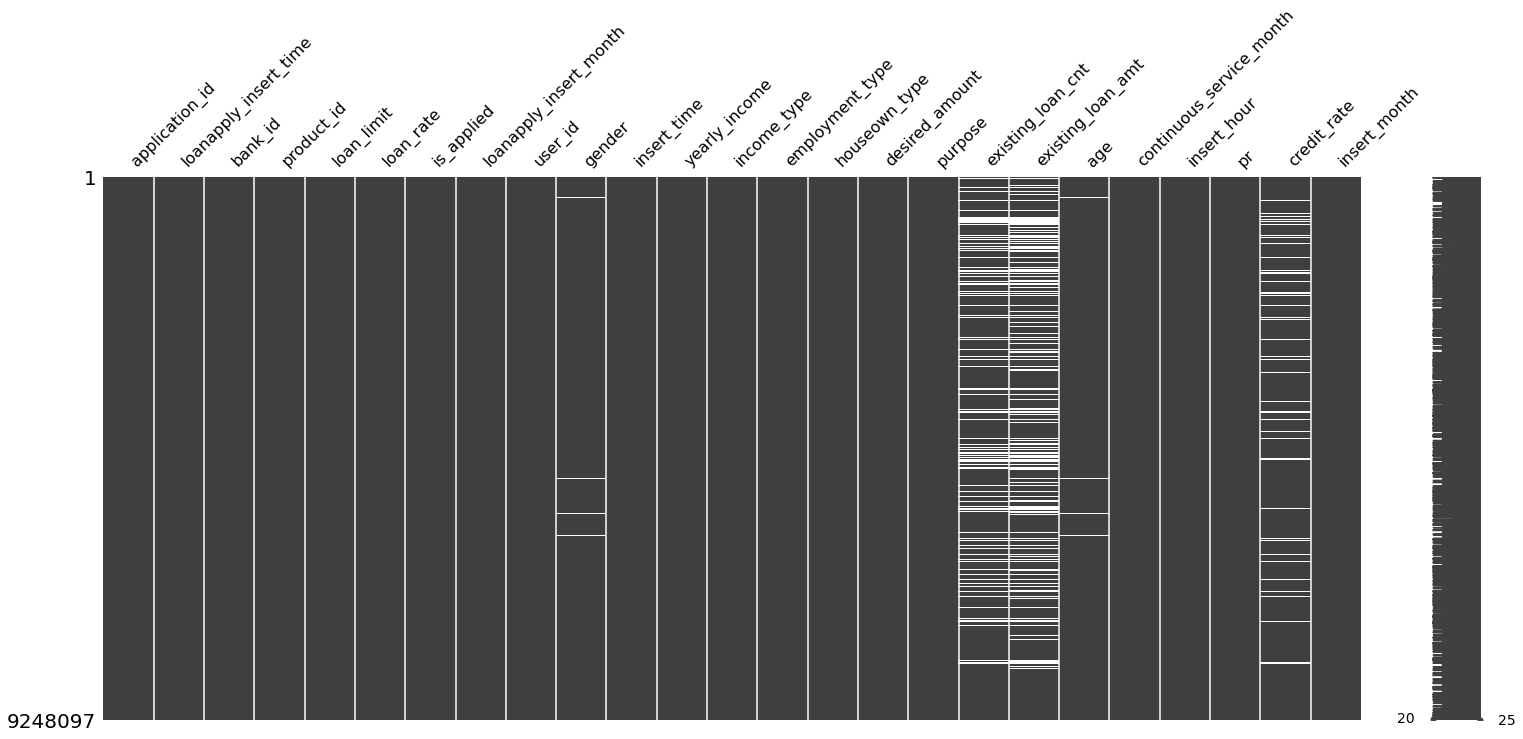

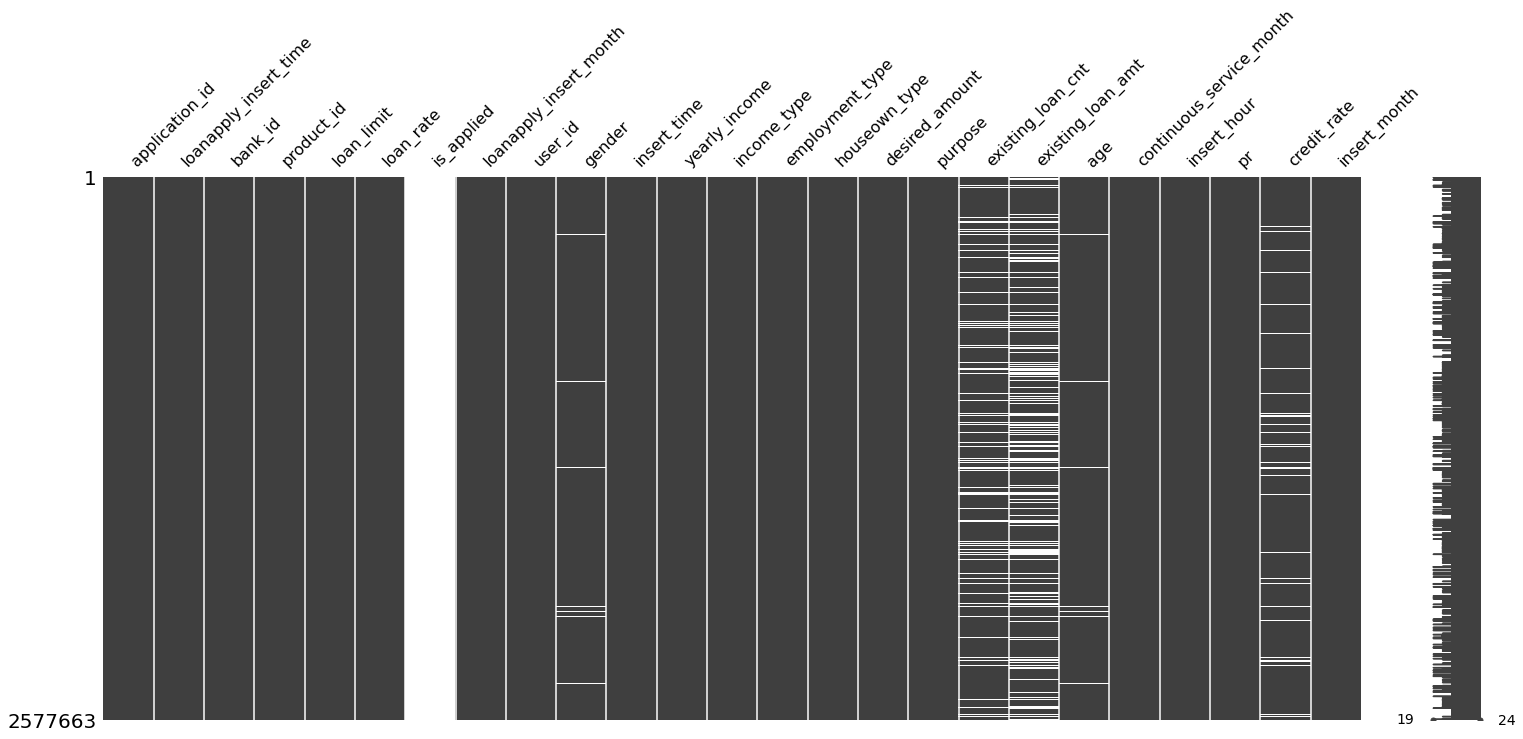

In [ ]:
display(msno.matrix(loan_spec_train))
display(msno.matrix(loan_spec_test))

In [ ]:
loan_spec_train.dropna(inplace=True)

# loan_spec_test.columns.to_list()
loan_spec_test.dropna(subset=['application_id',
 'loanapply_insert_time',
 'bank_id',
 'product_id',
 'loan_limit',
 'loan_rate',
 'loanapply_insert_month',
 'user_id',
 'gender',
 'insert_time',
 'credit_rate',
 'yearly_income',
 'income_type',
 'employment_type',
 'houseown_type',
 'desired_amount',
 'purpose',
 'existing_loan_cnt',
 'existing_loan_amt',
 'age',
 'continuous_service_month',
 'pr',
 'insert_month'], inplace=True)

> after

<AxesSubplot:>

<AxesSubplot:>

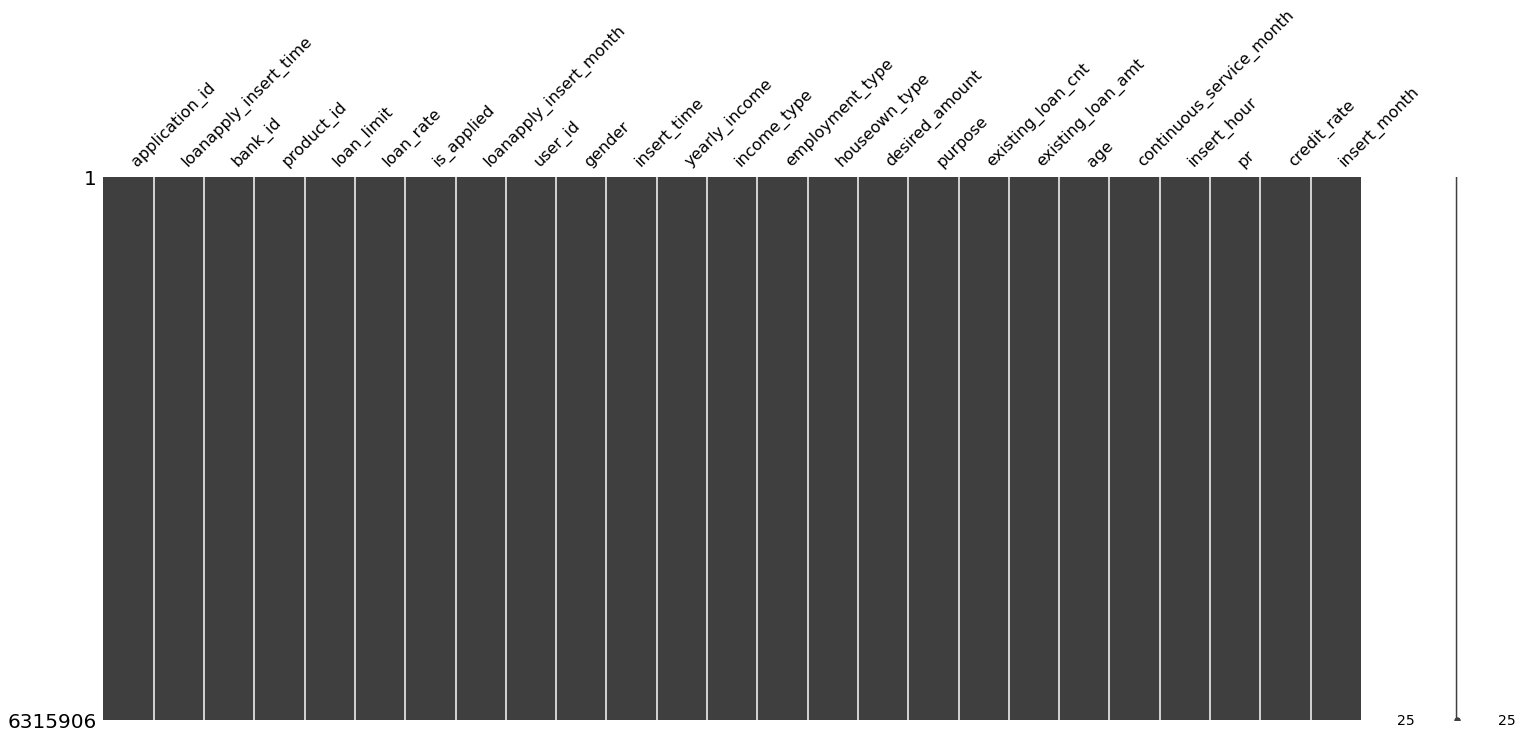

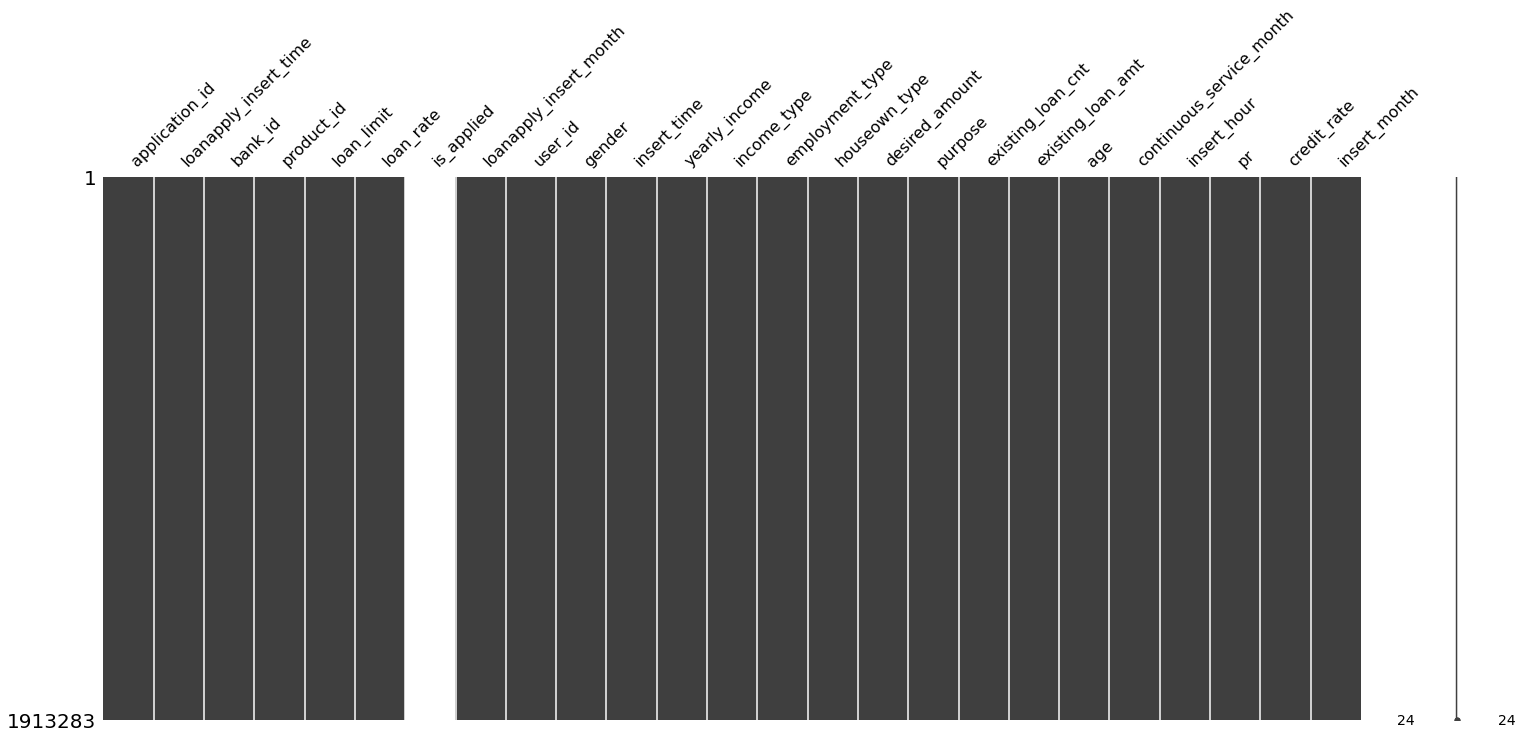

In [ ]:
display(msno.matrix(loan_spec_train))
display(msno.matrix(loan_spec_test))

In [ ]:
loan_spec_train.drop(columns=['loanapply_insert_time','loanapply_insert_month','insert_time'], axis=0, inplace=True)

In [ ]:
loan_spec_test.drop(columns=['loanapply_insert_time','loanapply_insert_month','insert_time'], axis=0, inplace=True)

# 8. loan_spec_train 데이터 학습하기

## 8.1. train_test_split 
> test_size=0.2, random_state=1

In [ ]:
X = loan_spec_train.drop(['is_applied'], axis=1)
y = loan_spec_train['is_applied']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape , X_test.shape)

(5052724, 21) (1263182, 21)


## 8.2. Scaling

In [ ]:
from sklearn.preprocessing import RobustScaler

Scaler = RobustScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

## 8.3. 평가 함수 생성

In [ ]:
def eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, f1-score:{3:.4f}'.format(accuracy*100, precision*100, recall*100, f1*100))

# 9. 분류기 선택 비교

## 9.1. RandomForest __vs__ XGboost

In [ ]:
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=3)

evals = [(X_train, y_train), (X_test, y_test)]

xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=evals, verbose=True)

xgb_preds = xgb.predict(X_test)

C:\Users\stat\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\stat\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73126	validation_1-auc:0.73288
[1]	validation_0-auc:0.73489	validation_1-auc:0.73641
[2]	validation_0-auc:0.77687	validation_1-auc:0.77806
[3]	validation_0-auc:0.77731	validation_1-auc:0.77843
[4]	validation_0-auc:0.78550	validation_1-auc:0.78640
[5]	validation_0-auc:0.78223	validation_1-auc:0.78332
[6]	validation_0-auc:0.78571	validation_1-auc:0.78650
[7]	validation_0-auc:0.78599	validation_1-auc:0.78687
[8]	validation_0-auc:0.79019	validation_1-auc:0.79104
[9]	validation_0-auc:0.78877	validation_1-auc:0.78975
[10]	validation_0-auc:0.79061	validation_1-auc:0.79146
[11]	validation_0-auc:0.79112	validation_1-auc:0.79194
[12]	validation_0-auc:0.79285	validation_1-auc:0.79367
[13]	validation_0-auc:0.79345	validation_1-auc:0.79424
[14]	validation_0-auc:0.79396	validation_1-auc:0.79478
[15]	validation_0-auc:0.79451	validation_1-auc:0.79535
[16]	validation_0-auc:0.79520	validation_1-auc:0.79597
[17]	validation_0-auc:0.79733	validation_1-auc:0.79796
[18]	validation_0-au

[149]	validation_0-auc:0.85086	validation_1-auc:0.85057
[150]	validation_0-auc:0.85091	validation_1-auc:0.85062
[151]	validation_0-auc:0.85121	validation_1-auc:0.85091
[152]	validation_0-auc:0.85123	validation_1-auc:0.85093
[153]	validation_0-auc:0.85144	validation_1-auc:0.85114
[154]	validation_0-auc:0.85151	validation_1-auc:0.85121
[155]	validation_0-auc:0.85157	validation_1-auc:0.85127
[156]	validation_0-auc:0.85163	validation_1-auc:0.85133
[157]	validation_0-auc:0.85183	validation_1-auc:0.85151
[158]	validation_0-auc:0.85185	validation_1-auc:0.85152
[159]	validation_0-auc:0.85200	validation_1-auc:0.85167
[160]	validation_0-auc:0.85206	validation_1-auc:0.85173
[161]	validation_0-auc:0.85214	validation_1-auc:0.85181
[162]	validation_0-auc:0.85211	validation_1-auc:0.85177
[163]	validation_0-auc:0.85227	validation_1-auc:0.85191
[164]	validation_0-auc:0.85234	validation_1-auc:0.85198
[165]	validation_0-auc:0.85238	validation_1-auc:0.85202
[166]	validation_0-auc:0.85242	validation_1-auc:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

rf.fit(X_train_scaled, y_train)

rf_pred = rf.predict(X_test_scaled)

## 9.2. 모델검정

In [ ]:
eval(y_test, xgb_preds)

Confusion Matrix
[[1186831    1954]
 [  72240    2157]]
정확도:94.1264, 정밀도:52.4690, 재현율:2.8993, f1-score:5.4950


In [ ]:
eval(y_test, rf_pred)

Confusion Matrix
[[1181807    6978]
 [  66526    7871]]
정확도:94.1810, 정밀도:53.0069, 재현율:10.5797, f1-score:17.6389


## 9.2.1. ROC곡선

C:\Users\stat\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


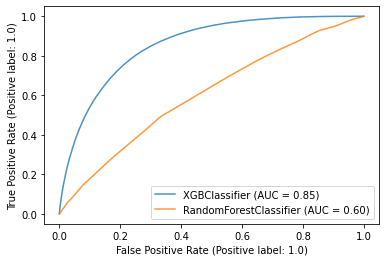

In [ ]:
ax = plt.gca()
xgb_disp = RocCurveDisplay.from_estimator(xgb, X_test, y_test, ax=ax, alpha=0.8) 
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

# 10. 최종 분류기 : RandomForest

- RandomForest 선택
> f1-score, 정확도 비교 결과 모두 랜덤포레스트 분류기가 우세

## 10.1. 특성 중요도 시각화

In [ ]:
def plot_feature_importance(model):
    n_features = len(X_train.columns)
    plt.barh(np.arange(n_features), sorted(model.feature_importances_), align='center', color='#5B5FEF')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.title('feature importance')
    plt.xlabel('rate')
    plt.ylim(-1, n_features)

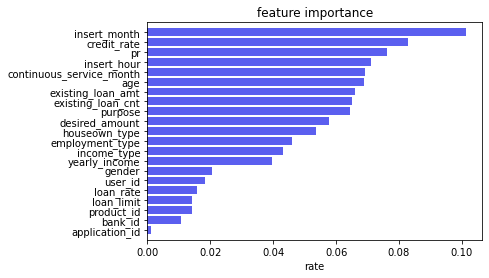

In [ ]:
plot_feature_importance(rf)

## 10.2. RF 최적 파라미터 grid_search
> 컴퓨팅 파워의 한계로 인해 분석 진행 불가

In [ ]:
# from sklearn.model_selection import GridSearchCV

# params = { 'n_estimators' : [100, 200],
#            'max_depth' : [6, 8, 10, 12],
#            'min_samples_leaf' : [8, 12, 18],
#            'min_samples_split' : [8, 16, 20]
#             }

# # RandomForestClassifier 객체 생성 후 GridSearchCV 수행
# rf_clf = RandomForestClassifier(random_state=10, n_jobs=-1)
# grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
# grid_cv.fit(X_train, y_train)

# print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
# print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [ ]:
# model = grid_cv.best_estimator_
# model.fit(X_train, y_train)
# pred = model.predict(X_test)
# eval(y_test, pred)

In [ ]:
# from sklearn.metrics import RocCurveDisplay

# ax = plt.gca()
# model = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)
# plt.show()

# 11. loan_spec_test 예측

In [ ]:
loan_spec_test.drop(['is_applied'],axis=1,inplace=True)
real_test_pred = rf.predict(loan_spec_test.values)

loan_spec_test['is_applied'] = real_test_pred
loan_spec_test['is_applied'].value_counts()

0.0    1082714
1.0     830569
Name: is_applied, dtype: int64

## 11.1. 예측된 신청자 수 비율 시각화

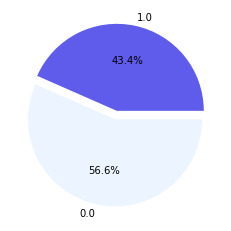

In [ ]:
ratio = loan_spec_test['is_applied'].value_counts().to_list()
labels = loan_spec_test['is_applied'].value_counts().index.to_list()
explode = [0.05, 0.05]
colors = ['#ECF5FF','#5F5BEB']

plt.figure(figsize=(4,4), facecolor='white')
plt.pie(ratio, labels=labels, autopct='%.1f%%', counterclock=False, explode=explode, colors=colors)
plt.show()

In [ ]:
final = loan_spec_test[['application_id', 'product_id', 'is_applied']]

# 12. 결과 제출

In [ ]:
result = pd.read_csv('데이터분석분야_퓨처스부문_쑥떡_평가데이터_제공.csv')
result.drop(['is_applied'], axis=1, inplace=True)

In [ ]:
result_merge = pd.merge(result, final, on=['application_id', 'product_id'], how = 'left')

In [ ]:
result_merge.dropna(subset=['is_applied'], axis=0, inplace=True)

## 결과 제출

In [ ]:
result_merge.to_csv('./../데이터분석분야_퓨처스부문_쑥떡_평가데이터.csv', index=False)
result_merge.to_csv('./../평가데이터/데이터분석분야_퓨처스부문_쑥떡_평가데이터.csv', index=False)